# Livrable 2 - Débruiter les images

## __Sommaire__
1. [Sommaire](#Sommaire)
2. [Introduction](#Introduction)
3. [Imports](#Imports-des-fonctions-et-datasets)
    * [Liste des imports](#Liste-des-imports)
    * [Load dataset](#Load-dataset)
4. [Ajouter du bruit](#Ajouter-du-bruit)
5. [Création du model](#Création-du-model)
6. [Entrainement](#Entrainement)
7. [Résultat](#Résultat)
8. [Sauvegarde du model et réutilisation](#Sauvegarde-du-model-et-réutilisation)
    * [Sauvegarde](#Sauvegarde)
    * [Récupération](#Récupération)
9. [Conclusion](#Conclusion)

## Introduction

L'objectif de ce livrable est d'assurer que les documents qui ont été classifié comme des photos sont bien utilisables. Afin de réaliser le captionning dans le troisième livrable nous utilisons un débruitage.

Cette étape va consister à compresser les images pour ne garder que l'information importante avant de les reconstituer sans le bruit. Pour ce faire nous allons entrainer un auto-encodeur convolutif à reproduire des images sans bruit.

Le dataset n'étant pas particulièrement bruité, nous rajoutons du bruit pour l'entrainement du model.

Dans l'ordre nous devons donc [ajouter](#Ajouter-du-bruit) du bruit sur notre dataset, [créer](#Création-du-model) puis [entrainner](#Entrainement) notre model et enfin [mesurer](#Résultat) son efficacité.

## Imports des fonctions et datasets

### Liste des imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from skimage.util import random_noise

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### Load dataset

Nous réutilisons la même fonction d'import du dataset qu'au premier livrable mais on ne cible que les photos. Nos images ont toutes le même format de 128 sur 128 avec 3 composantes pour le RGB.

In [12]:
def loadDataSet(path_datasets, size):
    return (
        tf.keras.preprocessing.image_dataset_from_directory(
          f"{path_datasets}/train",
          validation_split=0.2,
          subset="training",
          seed=42,
          labels="inferred",
          image_size=size
        ),
        tf.keras.preprocessing.image_dataset_from_directory(
          f"{path_datasets}/train",
          validation_split=0.2,
          subset="validation",
          seed=42,
          labels="inferred",
          image_size=size
        ),
        tf.keras.preprocessing.image_dataset_from_directory(
             f"{path_datasets}/test",
            labels="inferred",
            image_size=size
        )
    )

#chemin personel des images considéré comme Photo
path = "../datasets/dataset_128/dataset/Photo/"

train, validate, test = loadDataSet(path, (128, 128))

Found 7975 files belonging to 1 classes.
Using 6380 files for training.
Found 7975 files belonging to 1 classes.
Using 1595 files for validation.
Found 2025 files belonging to 1 classes.


## Ajouter du bruit

Nous allons utiliser plusieurs méthodes pour recréer un bruit moyen sur nos images à l'aide de la bibliothèque Skimage. La plus simple est l'ajout d'un bruit aléatoire gaussien mais nous allons cumuler plusieurs méthodes pour rendre le bruit plus réaliste. En parallèle on s'assure que les images ne contiennent que des valeurs entre 0 et 1 plutot que 0 et 255 afin que notre fonction de loss ne soit pas perturbée par de trop grandes valeurs. 

### Bruiter une image

In [4]:
# fonction de bruit simple ajout gaussian

def add_noise(data):
    new_data = random_noise(data, mode='gaussian', mean=0, var=0.05)
    
    new_data = random_noise(data, mode='s&p', amount=0.3, salt_vs_pepper=0.5)
    
    
    new_data = random_noise(data, mode='poisson')
    
    new_data = random_noise(data, mode='speckle', mean=0, var=0.05)
    return new_data

Exemple d'une image avec et sans bruit


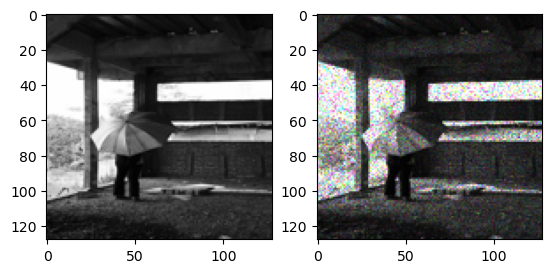

In [5]:
print("Exemple d'une image avec et sans bruit")

for image,label in train.take(1):
    
    data = image[0].numpy().astype("uint8")
    noise_data = add_noise(data)

    ax = plt.subplot(1, 2, 1)
    plt.imshow(data)
    ax = plt.subplot(1, 2, 2)
    plt.imshow(noise_data)

### Bruiter les datasets

Au lieu de garder la struture de dataset de tensorflow, nous allons utiliser des listes pour stocker nos images bruitées. Cela nous permet une manipulation plus simple pour la suite.

In [6]:
# Création des listes d'images à partir des datasets d'entrainement

noisy_train = []
clean_train = []

for images,label in train.take(-1):
    for i in range(len(images)):
        image = images[i].numpy().astype("uint8")
        noised_image = add_noise(image)
        clean_train.append(image)
        noisy_train.append(noised_image)

noisy_train = np.array(noisy_train)
clean_train = np.array(clean_train)
# Rescaling de la version non-bruitée
clean_train = clean_train/255

noisy_train.shape,clean_train.shape        
        

((6380, 128, 128, 3), (6380, 128, 128, 3))

In [7]:
# Création des listes d'images à partir des datasets de validation

noisy_validate = []
clean_validate = []

for images,label in validate.take(-1):
    for i in range(len(images)):
        image = images[i].numpy().astype("uint8")
        noised_image = add_noise(image)
        clean_validate.append(image)
        noisy_validate.append(noised_image)
        
noisy_validate = np.array(noisy_validate)
clean_validate = np.array(clean_validate)
# Rescaling de la version non-bruitée
clean_validate = clean_validate/255

In [13]:
# Création des listes d'images à partir des datasets de test

noisy_test = []
clean_test = []

for images,label in test.take(-1):
    for i in range(len(images)):
        image = images[i].numpy().astype("uint8")
        noised_image = add_noise(image)
        clean_test.append(image)
        noisy_test.append(noised_image)
        
noisy_test = np.array(noisy_test)
clean_test = np.array(clean_test)
# Rescaling de la version non-bruitée
clean_test = clean_test/255

## Création du model

Le model est composé de 2 parties : l'encodeur qui réalisent des convolutions et le décodeur qui les inversent. Nous conservons un espace latent de dimension 8 * 8 * 64 .  

Nous utilisons la MSE comme fonction de loss pour suivre l'efficacité de notre model.

Schéma de l'encodeur
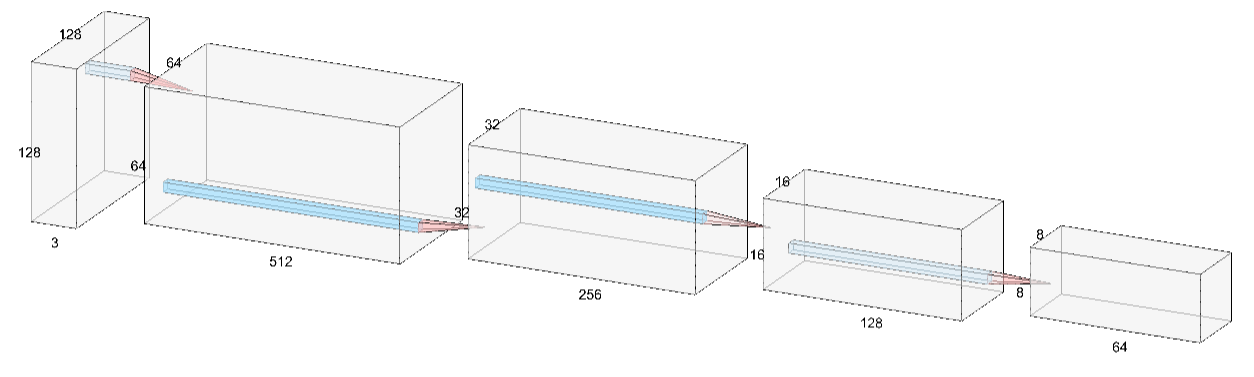


Schéma du décodeur

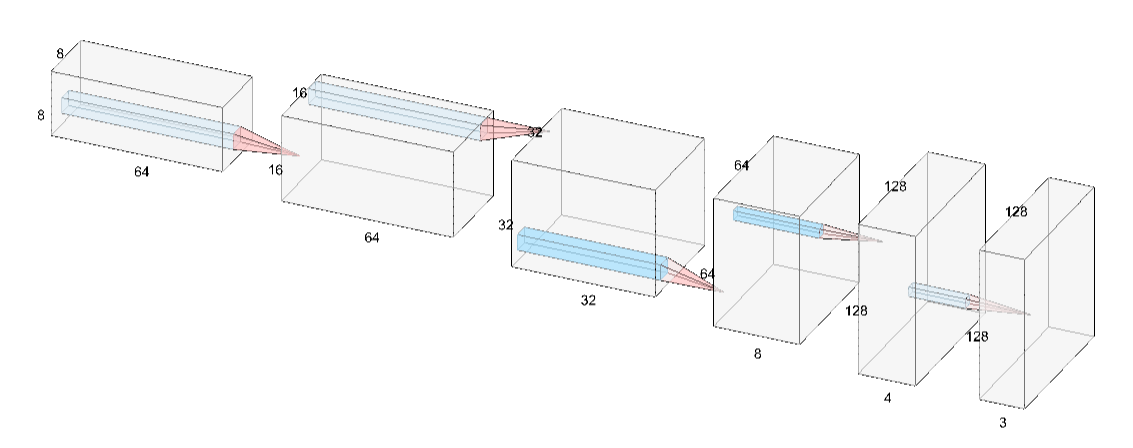

In [18]:
def denoises_model():
         
        
    #Encodeur

    inputs = keras.Input(shape=(128,128,3))
    x = layers.Conv2D(512, 3, activation="relu", strides=2, padding="same")(inputs)
    x1 = layers.Conv2D(256, 3, activation="relu", strides=2, padding="same")(x)    
    x2 = layers.Conv2D(128, 3, activation="relu", strides=2, padding="same")(x1)
    x3 = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x2)
    
    encodeur = keras.Model(inputs, x3, name="encodeur")

    encodeur.summary()
    
    #Decodeur
    inputs = keras.Input(shape=(8,8,64))

    z = layers.Conv2DTranspose(64, 5, activation="relu",strides=2, padding="same")(inputs)
    z1 = layers.Conv2DTranspose(32, 5, activation="relu",strides=2, padding="same")(z)
    z2 = layers.Conv2DTranspose(8, 5, activation="relu",strides=2, padding="same")(z1)
    z3 = layers.Conv2DTranspose(4, 3, activation="relu",strides=2, padding="same")(z2)
    
    outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(z3)
    
    
    decodeur = keras.Model(inputs, outputs, name="decodeur")

    decodeur.summary()

    
    # Auto-encodeur
    inputs = keras.Input(shape=(128,128,3))
    latents = encodeur(inputs)
    outputs = decodeur(latents)
    
    auto_encodeur = keras.Model(inputs,outputs, name="auto_encodeur")
    
    auto_encodeur.compile(optimizer='adam',
              loss=tf.keras.losses.MeanSquaredError())
    
    return auto_encodeur

auto_encodeur_model = denoises_model()

Model: "encodeur"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_4 (Conv2D)           (None, 64, 64, 512)       14336     
                                                                 
 conv2d_5 (Conv2D)           (None, 32, 32, 256)       1179904   
                                                                 
 conv2d_6 (Conv2D)           (None, 16, 16, 128)       295040    
                                                                 
 conv2d_7 (Conv2D)           (None, 8, 8, 64)          73792     
                                                                 
Total params: 1,563,072
Trainable params: 1,563,072
Non-trainable params: 0
_________________________________________________________________
Model: "decodeur"
______________________________

Au total notre model contient 1 732 579 paramètres entraînables majoritairement dans la partie encodeur.

## Entrainement

On entraine d'abord le model à reconnaitre l'image non bruitée avant de lui donner le set bruité. Cela permet de réduire le temps d'entrainnement au début.

In [19]:
history = auto_encodeur_model.fit(clean_train,clean_train,validation_data=(clean_validate, clean_validate),
                           epochs=6)

Epoch 1/6
200/200 [==============================] - 274s 1s/step - loss: 0.0433 - val_loss: 0.0344
Epoch 2/6
200/200 [==============================] - 289s 1s/step - loss: 0.0296 - val_loss: 0.0264
Epoch 3/6
200/200 [==============================] - 291s 1s/step - loss: 0.0242 - val_loss: 0.0222
Epoch 4/6
200/200 [==============================] - 281s 1s/step - loss: 0.0176 - val_loss: 0.0109
Epoch 5/6
200/200 [==============================] - 281s 1s/step - loss: 0.0098 - val_loss: 0.0093
Epoch 6/6
200/200 [==============================] - 285s 1s/step - loss: 0.0085 - val_loss: 0.0081


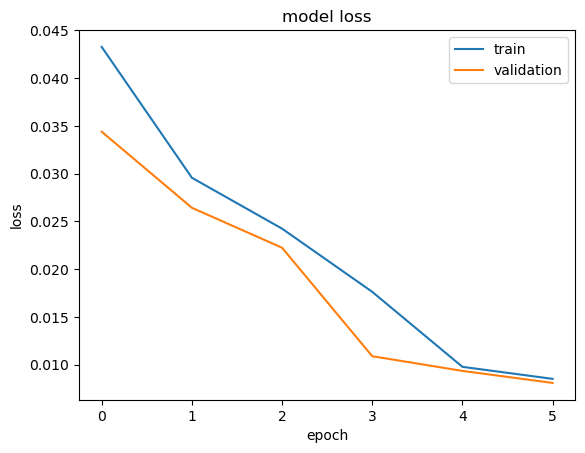

In [20]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [21]:
history2 = auto_encodeur_model.fit(noisy_train,clean_train,validation_data=(noisy_validate, clean_validate),
                           epochs=20)

Epoch 1/20
200/200 [==============================] - 290s 1s/step - loss: 0.0080 - val_loss: 0.0078
Epoch 2/20
200/200 [==============================] - 284s 1s/step - loss: 0.0075 - val_loss: 0.0074
Epoch 3/20
200/200 [==============================] - 284s 1s/step - loss: 0.0071 - val_loss: 0.0072
Epoch 4/20
200/200 [==============================] - 281s 1s/step - loss: 0.0068 - val_loss: 0.0067
Epoch 5/20
200/200 [==============================] - 281s 1s/step - loss: 0.0066 - val_loss: 0.0064
Epoch 6/20
200/200 [==============================] - 286s 1s/step - loss: 0.0064 - val_loss: 0.0064
Epoch 7/20
200/200 [==============================] - 270s 1s/step - loss: 0.0063 - val_loss: 0.0062
Epoch 8/20
200/200 [==============================] - 272s 1s/step - loss: 0.0062 - val_loss: 0.0068
Epoch 9/20
200/200 [==============================] - 275s 1s/step - loss: 0.0061 - val_loss: 0.0064
Epoch 10/20
200/200 [==============================] - 270s 1s/step - loss: 0.0061 - val_lo

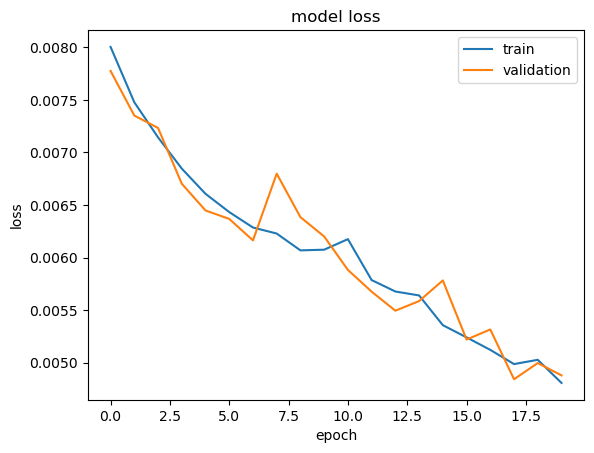

In [22]:
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [23]:
history3 = auto_encodeur_model.fit(noisy_train,clean_train,validation_data=(noisy_validate, clean_validate),
                           epochs=10)

Epoch 1/10
200/200 [==============================] - 288s 1s/step - loss: 0.0048 - val_loss: 0.0049
Epoch 2/10
200/200 [==============================] - 281s 1s/step - loss: 0.0047 - val_loss: 0.0048
Epoch 3/10
200/200 [==============================] - 282s 1s/step - loss: 0.0046 - val_loss: 0.0046
Epoch 4/10
200/200 [==============================] - 282s 1s/step - loss: 0.0046 - val_loss: 0.0047
Epoch 5/10
200/200 [==============================] - 287s 1s/step - loss: 0.0045 - val_loss: 0.0044
Epoch 6/10
200/200 [==============================] - 286s 1s/step - loss: 0.0045 - val_loss: 0.0045
Epoch 7/10
200/200 [==============================] - 286s 1s/step - loss: 0.0044 - val_loss: 0.0045
Epoch 8/10
200/200 [==============================] - 287s 1s/step - loss: 0.0043 - val_loss: 0.0046
Epoch 9/10
200/200 [==============================] - 285s 1s/step - loss: 0.0043 - val_loss: 0.0042
Epoch 10/10
200/200 [==============================] - 283s 1s/step - loss: 0.0043 - val_lo

In [24]:
history4 = auto_encodeur_model.fit(noisy_train,clean_train,validation_data=(noisy_validate, clean_validate),
                           epochs=10)

Epoch 1/10
200/200 [==============================] - 290s 1s/step - loss: 0.0042 - val_loss: 0.0043
Epoch 2/10
200/200 [==============================] - 284s 1s/step - loss: 0.0042 - val_loss: 0.0043
Epoch 3/10
200/200 [==============================] - 286s 1s/step - loss: 0.0041 - val_loss: 0.0043
Epoch 4/10
200/200 [==============================] - 283s 1s/step - loss: 0.0041 - val_loss: 0.0042
Epoch 5/10
200/200 [==============================] - 287s 1s/step - loss: 0.0041 - val_loss: 0.0041
Epoch 6/10
200/200 [==============================] - 286s 1s/step - loss: 0.0040 - val_loss: 0.0040
Epoch 7/10
200/200 [==============================] - 291s 1s/step - loss: 0.0040 - val_loss: 0.0040
Epoch 8/10
200/200 [==============================] - 291s 1s/step - loss: 0.0040 - val_loss: 0.0041
Epoch 9/10
200/200 [==============================] - 279s 1s/step - loss: 0.0040 - val_loss: 0.0039
Epoch 10/10
200/200 [==============================] - 287s 1s/step - loss: 0.0039 - val_lo

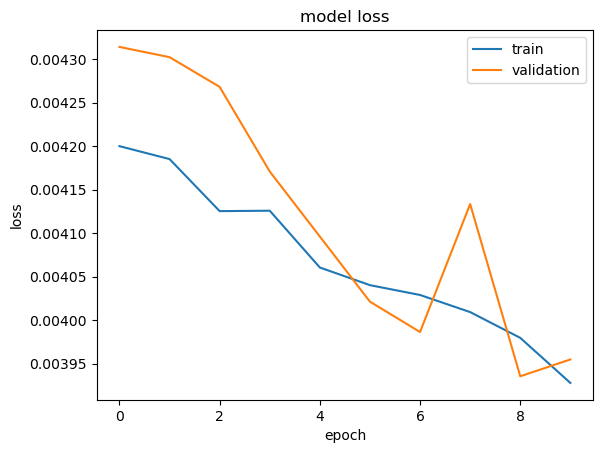

In [27]:
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

## Résultat

On obtient une loss inférieure à 0.005 après quelques époques et on ne remarque pas de surapprentissage. La valeur de loss fini par ce stabiliser vers 0.004 sans que la val_loss ne remonte (la progression peut continuer mais demande beaucoup d'époque supplémentaires). Pour visualiser ce que cela représente on affiche une image aléatoire du jeu de test avec et sans bruit, avant et après débruitage.  

In [14]:
predictions = auto_encodeur_model.predict(clean_test)
noise_predictions = auto_encodeur_model.predict(noisy_test)

200/200 [==============================] - 58s 292ms/step


(-0.5, 127.5, 127.5, -0.5)

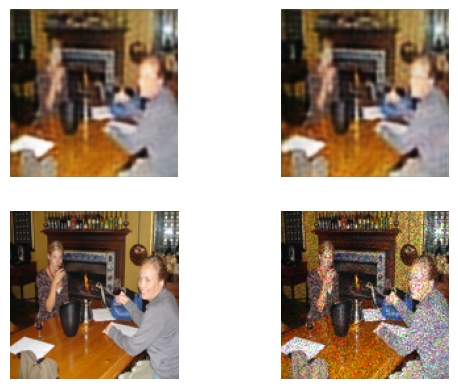

In [16]:
#Exemple de photo

photo = 505

#Sortie de l'image non bruitée
ax = plt.subplot(2, 2, 1)
plt.title("Sortie de l'image non bruitée")
plt.imshow(predictions[photo])
plt.axis("off")

#Sortie de l'image bruitée
ax = plt.subplot(2, 2, 2)
plt.title("Sortie de l'image bruitée")
plt.imshow(noise_predictions[photo])
plt.axis("off")

# Image non bruitée
ax = plt.subplot(2, 2, 3)
plt.title("Image non bruitée")
plt.imshow(clean_train[photo])
plt.axis("off")

# Image bruitée
ax = plt.subplot(2, 2, 4)
plt.title("Image bruitée")
plt.imshow(noisy_train[photo])
plt.axis("off")

## Sauvegarde du model et réutilisation

Pour réutiliser le model on le sauvegarde entièrement pour pouvoir le recharger et refaire des prédictions sans entrainnement.

### Sauvegarde

In [16]:
auto_encodeur_model.save('./model_livrable_2.cpt')

INFO:tensorflow:Assets written to: ./model_livrable_2.cpt\assets


INFO:tensorflow:Assets written to: ./model_livrable_2.cpt\assets


### Récupération

In [15]:
new_model = tf.keras.models.load_model('./model_livrable_2.cpt')


predictions = new_model.predict(clean_test)
noise_predictions = new_model.predict(noisy_test)

64/64 [==============================] - 6s 90ms/step


(-0.5, 127.5, 127.5, -0.5)

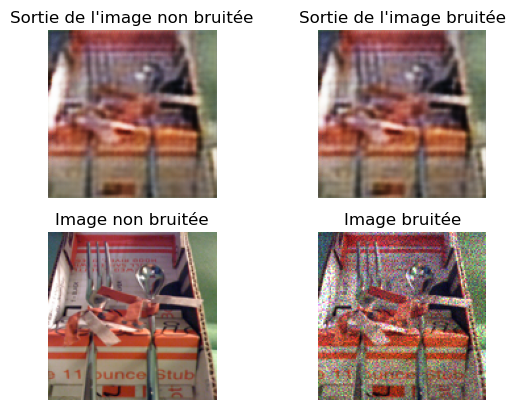

In [18]:
#Exemple de photo

photo = 505

#Sortie de l'image non bruitée
ax = plt.subplot(2, 2, 1)
plt.title("Sortie de l'image non bruitée")
plt.imshow(predictions[photo])
plt.axis("off")

#Sortie de l'image bruitée
ax = plt.subplot(2, 2, 2)
plt.title("Sortie de l'image bruitée")
plt.imshow(noise_predictions[photo])
plt.axis("off")

# Image non bruitée
ax = plt.subplot(2, 2, 3)
plt.title("Image non bruitée")
plt.imshow(clean_test[photo])
plt.axis("off")

# Image bruitée
ax = plt.subplot(2, 2, 4)
plt.title("Image bruitée")
plt.imshow(noisy_test[photo])
plt.axis("off")

## Conclusion

L'auto-encodeur produit permet de supprimer le bruit mais c'est au prix d'un peu de clarté de l'image. Il conserve les informations importante mais diminue celle des détails.

En cas d'images non bruitées dont nous réalisons le captionning, il faut mieux ne pas les faire passer par le débruitage.

